In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Topicos
!ls data

/content/drive/MyDrive/Topicos
english  kannada  kuzushiji


In [ ]:
'''
Dados disponíveis em:

English Handwritten Characters: https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset
Kuzushiji-MNIST: https://www.kaggle.com/datasets/anokas/kuzushiji
Kannada Handwritten Characters: https://www.kaggle.com/competitions/Kannada-MNIST
'''

# 1. Carregando dados

## 1.1 English Handwritten Characters

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
df = pd.read_csv("data/english/english.csv")
df.head()

,image,label
0,Img/img001-001.png,0
1,Img/img001-002.png,0
2,Img/img001-003.png,0
3,Img/img001-004.png,0
4,Img/img001-005.png,0


In [6]:
df["image"] = "data/english/" + df["image"]
df.head()

,image,label
0,data/english/Img/img001-001.png,0
1,data/english/Img/img001-002.png,0
2,data/english/Img/img001-003.png,0
3,data/english/Img/img001-004.png,0
4,data/english/Img/img001-005.png,0


(64, 64)


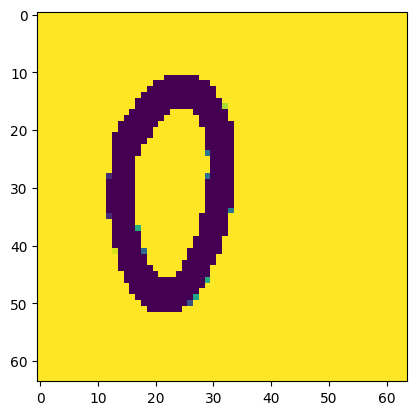

In [7]:
def img_to_arr(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(64,64))
    return img

print(img_to_arr(df['image'][0]).shape)
plt.imshow(img_to_arr(df['image'][0]), cmap='gray')

In [8]:
# Lendo imagens
import multiprocessing

with multiprocessing.Pool(4) as p:
    images = p.map(img_to_arr, df['image'])

In [9]:
len_img = df.shape[0]
x = np.array(images).reshape(len_img,64,64,1)
x.shape

(3410, 64, 64, 1)

2


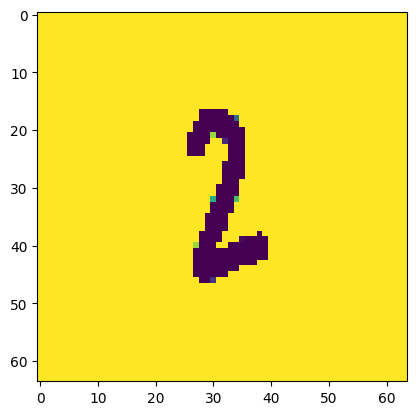

In [10]:
img = x[119].reshape((64,64,1))
plt.imshow(img, cmap='gray')
print(df['label'].iloc[119])

In [11]:
y = df['label']
le = LabelEncoder()
y_label = le.fit_transform(y)

In [12]:
train_images_english,test_images_english,train_labels_english,test_labels_english = train_test_split(x,y_label,test_size=0.2,random_state=42)
train_images_english = train_images_english/255.0
test_images_english = test_images_english/255.0

In [13]:
n_labels = max(y_label)+1

In [14]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import matplotlib.pyplot as plt
import os
import time

train_ds_english = tf.data.Dataset.from_tensor_slices((train_images_english, train_labels_english))
test_ds_english = tf.data.Dataset.from_tensor_slices((test_images_english, test_labels_english))

In [15]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    # Fazendo resize das imagens para um tamanho padrão de todas as redes 227x227
    image = tf.image.resize(image, (227,227))
    return image, label

In [16]:
train_ds_size_english = tf.data.experimental.cardinality(train_ds_english).numpy()
test_ds_size_english = tf.data.experimental.cardinality(test_ds_english).numpy()
print("Training data size:", train_ds_size_english)
print("Test data size:", test_ds_size_english)

Training data size: 2728
Test data size: 682


In [17]:
train_ds_english = (train_ds_english
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_english)
                  .batch(batch_size=32, drop_remainder=True))
test_ds_english = (test_ds_english
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_english)
                  .batch(batch_size=32, drop_remainder=True))

## 1.2 Kuzushiji-MNIST

In [18]:
train_images_kmnist = np.load('data/kuzushiji/kmnist-train-imgs.npz')['arr_0']
test_images_kmnist = np.load('data/kuzushiji/kmnist-test-imgs.npz')['arr_0']
train_labels_kmnist = np.load('data/kuzushiji/kmnist-train-labels.npz')['arr_0']
test_labels_kmnist = np.load('data/kuzushiji/kmnist-test-labels.npz')['arr_0']

In [19]:
train_images_kmnist = np.array(train_images_kmnist).reshape(*train_images_kmnist.shape, 1)
test_images_kmnist = np.array(test_images_kmnist).reshape(*test_images_kmnist.shape, 1)

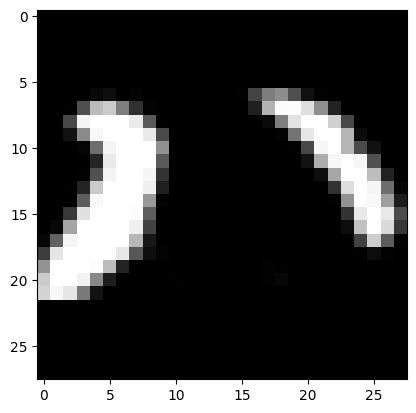

In [20]:
plt.imshow(train_images_kmnist[10], cmap='gray')
plt.show()

In [21]:
char_df = pd.read_csv('data/kuzushiji/kmnist_classmap.csv', encoding = 'utf-8')
char_df.head()

,index,codepoint,char
0,0,U+304A,お
1,1,U+304D,き
2,2,U+3059,す
3,3,U+3064,つ
4,4,U+306A,な


In [22]:
print("KMNIST train shape:", train_images_kmnist.shape)
print("KMNIST test shape:", test_images_kmnist.shape)
print("KMNIST train shape:", train_labels_kmnist.shape)
print("KMNIST test shape:", test_labels_kmnist.shape)
print("KMNIST character map shape:", char_df.shape)

KMNIST train shape: (60000, 28, 28, 1)
KMNIST test shape: (10000, 28, 28, 1)
KMNIST train shape: (60000,)
KMNIST test shape: (10000,)
KMNIST character map shape: (10, 3)


<ipython-input-23-47f57b5d998c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(10)):


  0%|          | 0/10 [00:00<?, ?it/s]

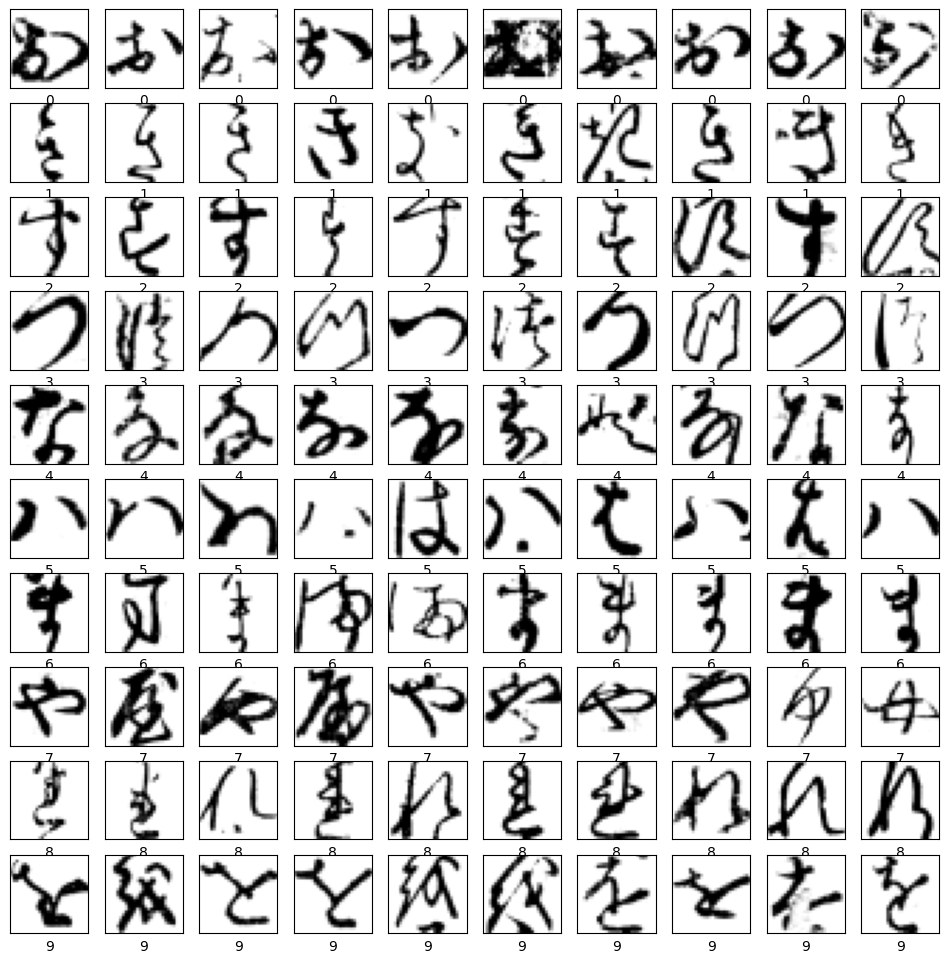

In [23]:
from tqdm import tqdm_notebook

def plot_sample_images_data(images, labels):
    plt.figure(figsize=(12,12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap=plt.cm.binary)
            plt.xlabel(lbls[j])

plot_sample_images_data(train_images_kmnist, train_labels_kmnist)

In [24]:
train_ds_kmnist = tf.data.Dataset.from_tensor_slices((train_images_kmnist, train_labels_kmnist))
test_ds_kmnist = tf.data.Dataset.from_tensor_slices((test_images_kmnist, test_labels_kmnist))

In [25]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    # Fazendo resize das imagens para um tamanho padrão de todas as redes 227x227
    image = tf.image.resize(image, (227,227))
    return image, label

train_ds_size_kmnist = tf.data.experimental.cardinality(train_ds_kmnist).numpy()
test_ds_size_kmnist = tf.data.experimental.cardinality(test_ds_kmnist).numpy()
print("Training data size:", train_ds_size_kmnist)
print("Test data size:", test_ds_size_kmnist)

Training data size: 60000
Test data size: 10000


In [26]:
train_ds_kmnist = (train_ds_kmnist
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_kmnist)
                  .batch(batch_size=32, drop_remainder=True))
test_ds_kmnist = (test_ds_kmnist
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_kmnist)
                  .batch(batch_size=32, drop_remainder=True))

## 1.3 Kannada Handwritten Characters

In [27]:
df = pd.read_csv("data/kannada/kannada.csv")
df.head()

,img,class
0,Img/img001-001.png,1
1,Img/img001-002.png,1
2,Img/img001-003.png,1
3,Img/img001-004.png,1
4,Img/img001-005.png,1


In [30]:
df["image"] = "data/kannada/" + df["img"]
df.head()

,img,class,image
0,Img/img001-001.png,1,data/kannada/Img/img001-001.png
1,Img/img001-002.png,1,data/kannada/Img/img001-002.png
2,Img/img001-003.png,1,data/kannada/Img/img001-003.png
3,Img/img001-004.png,1,data/kannada/Img/img001-004.png
4,Img/img001-005.png,1,data/kannada/Img/img001-005.png


In [39]:
df['image']

0        data/kannada/Img/img001-001.png
1        data/kannada/Img/img001-002.png
2        data/kannada/Img/img001-003.png
3        data/kannada/Img/img001-004.png
4        data/kannada/Img/img001-005.png
                      ...               
16420    data/kannada/Img/img657-021.png
16421    data/kannada/Img/img657-022.png
16422    data/kannada/Img/img657-023.png
16423    data/kannada/Img/img657-024.png
16424    data/kannada/Img/img657-025.png
Name: image, Length: 16425, dtype: object

(64, 64)


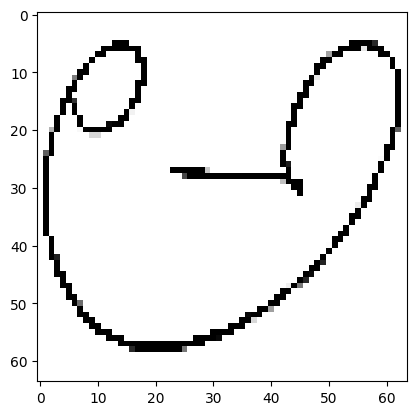

In [47]:
def img_to_arr(x):
    img = cv2.imread(x)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(64,64))
    return img

print(img_to_arr(df['image'][0]).shape)
plt.imshow(img_to_arr(df['image'][0]), cmap='gray')

In [48]:
# Lendo imagens
import multiprocessing

with multiprocessing.Pool(4) as p:
    images = p.map(img_to_arr, df['image'])

In [ ]:
len_img = df.shape[0]
x = np.array(images).reshape(len_img,64,64,1)
x.shape
img = x[119].reshape((64,64,1))
plt.imshow(img, cmap='gray')
print(df['label'].iloc[119])

In [ ]:
y = df['label']
le = LabelEncoder()
y_label = le.fit_transform(y)
train_images_kannada,test_images_kannada,train_labels_kannada,test_labels_kannada = train_test_split(x,y_label,test_size=0.2,random_state=42)
train_images_kannada = train_images_kannada/255.0
test_images_kannada = test_images_kannada/255.0

In [ ]:
n_labels = max(y_label)+1
train_ds_kannada = tf.data.Dataset.from_tensor_slices((train_images_kannada, train_labels_kannada))
test_ds_kannada = tf.data.Dataset.from_tensor_slices((test_images_kannada, test_labels_kannada))

In [ ]:
def process_images(image, label):
    image = tf.image.per_image_standardization(image)
    # Fazendo resize das imagens para um tamanho padrão de todas as redes 227x227
    image = tf.image.resize(image, (227,227))
    return image, label

In [ ]:
train_ds_size_kannada = tf.data.experimental.cardinality(train_ds_kannada).numpy()
test_ds_size_kannada = tf.data.experimental.cardinality(test_ds_kannada).numpy()
print("Training data size:", train_ds_size_kannada)
print("Test data size:", test_ds_size_kannada)

In [ ]:
train_ds_kannada = (train_ds_kannada
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_kannada)
                  .batch(batch_size=32, drop_remainder=True))
test_ds_kannada = (test_ds_kannada
                  .map(process_images)
                  .shuffle(buffer_size=train_ds_size_kannada)
                  .batch(batch_size=32, drop_remainder=True))

# 2. Treinamento das Redes

## 2.1 AlexNet

In [27]:
# Implementação da rede AlexNet usando a biblioteca Keras. Fonte: https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98

alexnet_noaug = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_labels, activation='softmax')
])

In [28]:
alexnet_noaug.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
alexnet_noaug.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        11712     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
#alexnet_noaug.fit(train_ds_english,epochs=10,batch_size=32,use_multiprocessing=True)
#alexnet_noaug.fit(train_ds_kmnist,epochs=10,batch_size=1,use_multiprocessing=True)
#alexnet_noaug.fit(train_ds_kannada,epochs=10,batch_size=1,use_multiprocessing=True)

Epoch 1/10


In [31]:
#alexnet_noaug.save('alexnet_noaug_english')
#alexnet_noaug.save('alexnet_noaug_kmnist')
#alexnet_noaug.save('alexnet_noaug_kannada')

## 2.2 DenseNet121

In [29]:
densenet_noaug = tf.keras.applications.DenseNet121(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(227,227,1),
    pooling=None,
    classes=n_labels,
    classifier_activation="softmax",
)

In [30]:
densenet_noaug.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
densenet_noaug.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 1  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 233, 233, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 114, 114, 64  3136        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
#densenet_noaug.fit(train_ds_english,epochs=10,batch_size=32,use_multiprocessing=True)
#densenet_noaug.fit(train_ds_kmnist,epochs=10,batch_size=8,use_multiprocessing=True)
#densenet_noaug.fit(train_ds_kannada,epochs=10,batch_size=8,use_multiprocessing=True)

Epoch 1/10


In [44]:
#densenet_noaug.save('mobile_noaug_english')
#densenet_noaug.save('mobile_noaug_kmnist')
#densenet_noaug.save('mobile_noaug_kannada')

## 2.3 ResNet50V2

In [33]:
resnet50v2_noaug = tf.keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(227,227,1),
    pooling=None,
    classes=n_labels,
    classifier_activation="softmax",
)

In [34]:
resnet50v2_noaug.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])
resnet50v2_noaug.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 233, 233, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 114, 114, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [35]:
#resnet50v2_noaug.fit(train_ds_english,epochs=10,batch_size=32,use_multiprocessing=True)
#resnet50v2_noaug.fit(train_ds_kmnist,epochs=10,batch_size=32,use_multiprocessing=True)
#resnet50v2_noaug.fit(train_ds_kannada,epochs=10,batch_size=32,use_multiprocessing=True)

Epoch 1/10
85/85 [==============================] - 48s 316ms/step - loss: 4.1725 - accuracy: 0.0151
Epoch 2/10
85/85 [==============================] - 28s 316ms/step - loss: 4.1416 - accuracy: 0.0180
Epoch 3/10
85/85 [==============================] - 28s 312ms/step - loss: 4.1201 - accuracy: 0.0188
Epoch 4/10
85/85 [==============================] - 28s 314ms/step - loss: 4.0999 - accuracy: 0.0265
Epoch 5/10
85/85 [==============================] - 28s 319ms/step - loss: 4.0859 - accuracy: 0.0346
Epoch 6/10
85/85 [==============================] - 28s 312ms/step - loss: 4.0749 - accuracy: 0.0309
Epoch 7/10
85/85 [==============================] - 28s 317ms/step - loss: 4.0574 - accuracy: 0.0423
Epoch 8/10
85/85 [==============================] - 27s 308ms/step - loss: 4.0409 - accuracy: 0.0471
Epoch 9/10
85/85 [==============================] - 28s 312ms/step - loss: 4.0229 - accuracy: 0.0500
Epoch 10/10
85/85 [==============================] - 28s 314ms/step - loss: 4.0065 - accura

In [36]:
#resnet50v2_noaug.save('resnet50v2_noaug_english')
#resnet50v2_noaug.save('resnet50v2_noaug_kmnist')
#resnet50v2_noaug.save('resnet50v2_noaug_kannada')

# 3. Spatial-Transformer-Networks

In [35]:
# Implementação baseada na disponível em https://github.com/sayakpaul/Spatial-Transformer-Networks-with-Keras

from tensorflow.keras import layers

AUTO = tf.data.AUTOTUNE
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 10

In [36]:
# Spatial transformer localization-network
def get_localization_network():
    localization = tf.keras.Sequential([
        layers.Conv2D(8, kernel_size=7, input_shape=(IMG_SIZE, IMG_SIZE, 1),
                      activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(strides=2),
        layers.Conv2D(10, kernel_size=5, activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(strides=2),
    ])
    return localization

# Regressor for the 3 * 2 affine matrix
def get_affine_params():
    output_bias = tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])
    fc_loc = tf.keras.Sequential([
        layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        layers.Dense(3 * 2, kernel_initializer="zeros", bias_initializer=output_bias)
    ])

    return fc_loc


In [37]:
def get_pixel_value(img, x, y):
    """
    Utility function to get pixel value for coordinate
    vectors x and y from a  4D tensor image.
    Input
    -----
    - img: tensor of shape (B, H, W, C)
    - x: flattened tensor of shape (B*H*W,)
    - y: flattened tensor of shape (B*H*W,)
    Returns
    -------
    - output: tensor of shape (B, H, W, C)
    """
    shape = tf.shape(x)
    batch_size = shape[0]
    height = shape[1]
    width = shape[2]

    batch_idx = tf.range(0, batch_size)
    batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
    b = tf.tile(batch_idx, (1, height, width))

    indices = tf.stack([b, y, x], 3)

    return tf.gather_nd(img, indices)

In [38]:
def affine_grid_generator(height, width, theta):
    """
    This function returns a sampling grid, which when
    used with the bilinear sampler on the input feature
    map, will create an output feature map that is an
    affine transformation [1] of the input feature map.
    Input
    -----
    - height: desired height of grid/output. Used
      to downsample or upsample.
    - width: desired width of grid/output. Used
      to downsample or upsample.
    - theta: affine transform matrices of shape (num_batch, 2, 3).
      For each image in the batch, we have 6 theta parameters of
      the form (2x3) that define the affine transformation T.
    Returns
    -------
    - normalized grid (-1, 1) of shape (num_batch, 2, H, W).
      The 2nd dimension has 2 components: (x, y) which are the
      sampling points of the original image for each point in the
      target image.
    Note
    ----
    [1]: the affine transformation allows cropping, translation,
         and isotropic scaling.
    """
    num_batch = tf.shape(theta)[0]

    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)

    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])

    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])

    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))

    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')

    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)

    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids

In [39]:
def bilinear_sampler(img, x, y):
    """
    Performs bilinear sampling of the input images according to the
    normalized coordinates provided by the sampling grid. Note that
    the sampling is done identically for each channel of the input.
    To test if the function works properly, output image should be
    identical to input image when theta is initialized to identity
    transform.
    Input
    -----
    - img: batch of images in (B, H, W, C) layout.
    - grid: x, y which is the output of affine_grid_generator.
    Returns
    -------
    - out: interpolated images according to grids. Same size as grid.
    """
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')

    # rescale x and y to [0, W-1/H-1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x-1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y-1, 'float32'))

    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)

    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)

    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')

    # calculate deltas
    wa = (x1-x) * (y1-y)
    wb = (x1-x) * (y-y0)
    wc = (x-x0) * (y1-y)
    wd = (x-x0) * (y-y0)

    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)

    # compute output
    out = tf.add_n([wa*Ia, wb*Ib, wc*Ic, wd*Id])

    return out


In [40]:
# Spatial transformer network forward function
def stn(x):
    localization = get_localization_network()
    fc_loc = get_affine_params()

    xs = localization(x)
    xs = tf.reshape(xs, (-1, 10 * 3 * 3 ))
    theta = fc_loc(xs)
    theta = tf.reshape(theta, (-1, 2, 3))

    grid = affine_grid_generator(28, 28, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    x = bilinear_sampler(x, x_s, y_s)

    return x

In [41]:
def get_training_model(use_stn=True):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 1))
    if use_stn:
        x = stn(inputs)
    else:
        x = inputs

    x = layers.Conv2D(10, (5, 5), activation="relu", kernel_initializer="he_normal")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(20, (5, 5), activation="relu", kernel_initializer="he_normal")(x)
    x = layers.SpatialDropout2D(0.5)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.reshape(x, (-1, 320))
    x = layers.Dense(50, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)

    return tf.keras.Model(inputs, outputs)

In [42]:
num_params_w_stn = get_training_model().count_params()
num_params_wo_stn = get_training_model(False).count_params()
print(f"Number of parameters with STN: {num_params_w_stn / 1e6} M")
print(f"Number of parameters without STN: {num_params_wo_stn / 1e6} M")

Number of parameters with STN: 0.02736 M
Number of parameters without STN: 0.02184 M


In [ ]:
# Data loaders
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

In [48]:

stn_model = get_training_model()
stn_mini_model = tf.keras.Model(stn_model.input, stn_model.layers[-10].output)
file_writer_cm = tf.summary.create_file_writer("logs/stn_progress")

# Courtesy: https://www.tensorflow.org/tensorboard/image_summaries
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)

    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def log_progression(epoch, logs):
    sampled_transformed = stn_mini_model(x_test[:25])

    figure = plt.figure(figsize=(10, 10))
    for n in range(25):
        plt.subplot(5, 5, n+1)
        plt.imshow(sampled_transformed[n].numpy().squeeze(), cmap="binary")
        plt.axis("off")

    progress_image = plot_to_image(figure)
    with file_writer_cm.as_default():
        tf.summary.image("Progression", progress_image, step=epoch)

# Define the per-epoch callback.
progress_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_progression)

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

In [48]:
stn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
stn_model.fit(train_ds, validation_data=val_ds,
              epochs=EPOCHS,
              callbacks=[es_callback, reduce_lr, progress_callback])

_, test_acc = stn_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))